<a href="https://colab.research.google.com/github/SrivikramMV/CSC2031/blob/main/CSC3831_Final_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC3831 Final Assessment - Part I: Data Engineering



In [2]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


In [3]:
display(houses_corrupted.head())

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,NaN,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,NaN,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


I have outputted a preview of the dataset, from which I can see the first five rows, showing features such as median_house_value, median_income, housing_median_age etc. Notably, some rows have missing values, for example the NaN in the population column for rows 2 and 3.

From an initial glance, the data looks generally consistent, with numeric values falling within the expected range of what I would expect housing data to look like. From initial observation, these records show presence of missing data, and potentially large variability in features like total_rooms and population, with some values in the 7000 and 2400 range, and some in the 900 and 200 range respectively.


In [4]:
print("Dataset shape:", houses_corrupted.shape)

print("\nInformation about the dataset:")
houses_corrupted.info()

Dataset shape: (20640, 9)

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


From the above output, I was able to determine the dataset’s size: 20,640 rows and 9 columns. Using the info() method revealed that all columns are of type float64, and also helped identify that three features - median_income, housing_median_age, and population - have fewer non-null counts, further indicating missing values. Through some calculation using this output, I determined that approximately 10% of these three features’ values are missing. This can be useful to explore later.  

Having no categorical values in the dataset makes the analysis easier, but I will have to be careful in analyzing how the data is distributed and handle any missing values in the numeric columns.


In [5]:
print("\nDescriptive Statistics:")
display(houses_corrupted.describe())


Descriptive Statistics:


,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,18576.000000,18576.000000,20640.000000,20640.000000,18576.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.929958,28.324182,2635.763081,537.898014,1488.069283,499.539680,35.631861,-119.569704
std,115395.615874,1.964296,12.584914,2181.615252,421.247906,1170.585810,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.560300,18.000000,1447.750000,295.000000,839.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.572400,28.000000,2127.000000,435.000000,1227.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.870050,37.000000,3148.000000,647.000000,1803.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


Using the descriptive stats above, I can see the central tendency and spread of each variable.

From my observation, I noticed that:

* median_house_value has a mean of ~206,856 and a max of 500,001, suggesting the data might be capped at the upper end.
* Features like total_rooms, total_bedrooms, population, and households are highly skewed. Their means are significantly lower than their maxima, indicating a few very large values.
* median_income ranges from about 0.5 to 15.0, with a standard deviation of ~1.96, showing wide variability.
* housing_median_age spans from 1 to 52 years, distributed relatively evenly, if not slightly skewed toward older properties.

These statistics confirm the presence of a broad range of values and potential outliers.


In [6]:
missing_counts = houses_corrupted.isnull().sum().sort_values(ascending=False)
print("\nMissing values per feature:")
print(missing_counts)

threshold = 0.1 # As I calculated roughly 10% of missing values from earlier, I chose a threshold of 0.1 here.
features_high_missing = missing_counts[missing_counts > threshold * houses_corrupted.shape[0]].index.tolist()
print("\nFeatures with more than 10% missing values:")
print(features_high_missing)


Missing values per feature:
median_income         2064
housing_median_age    2064
population            2064
median_house_value       0
total_rooms              0
total_bedrooms           0
households               0
latitude                 0
longitude                0
dtype: int64

Features with more than 10% missing values:
[]


As calculated earlier, median_income, housing_median_age, and population each have 2,064 missing values (~10% of the dataset). Other features have no missing values.

Given that none of these features surpass the 10% threshold by a large margin, none of them need to be flagged as having an excessive amount of missingness. However, 10% of missing data is still significant, so I will have to determine how to handle it.


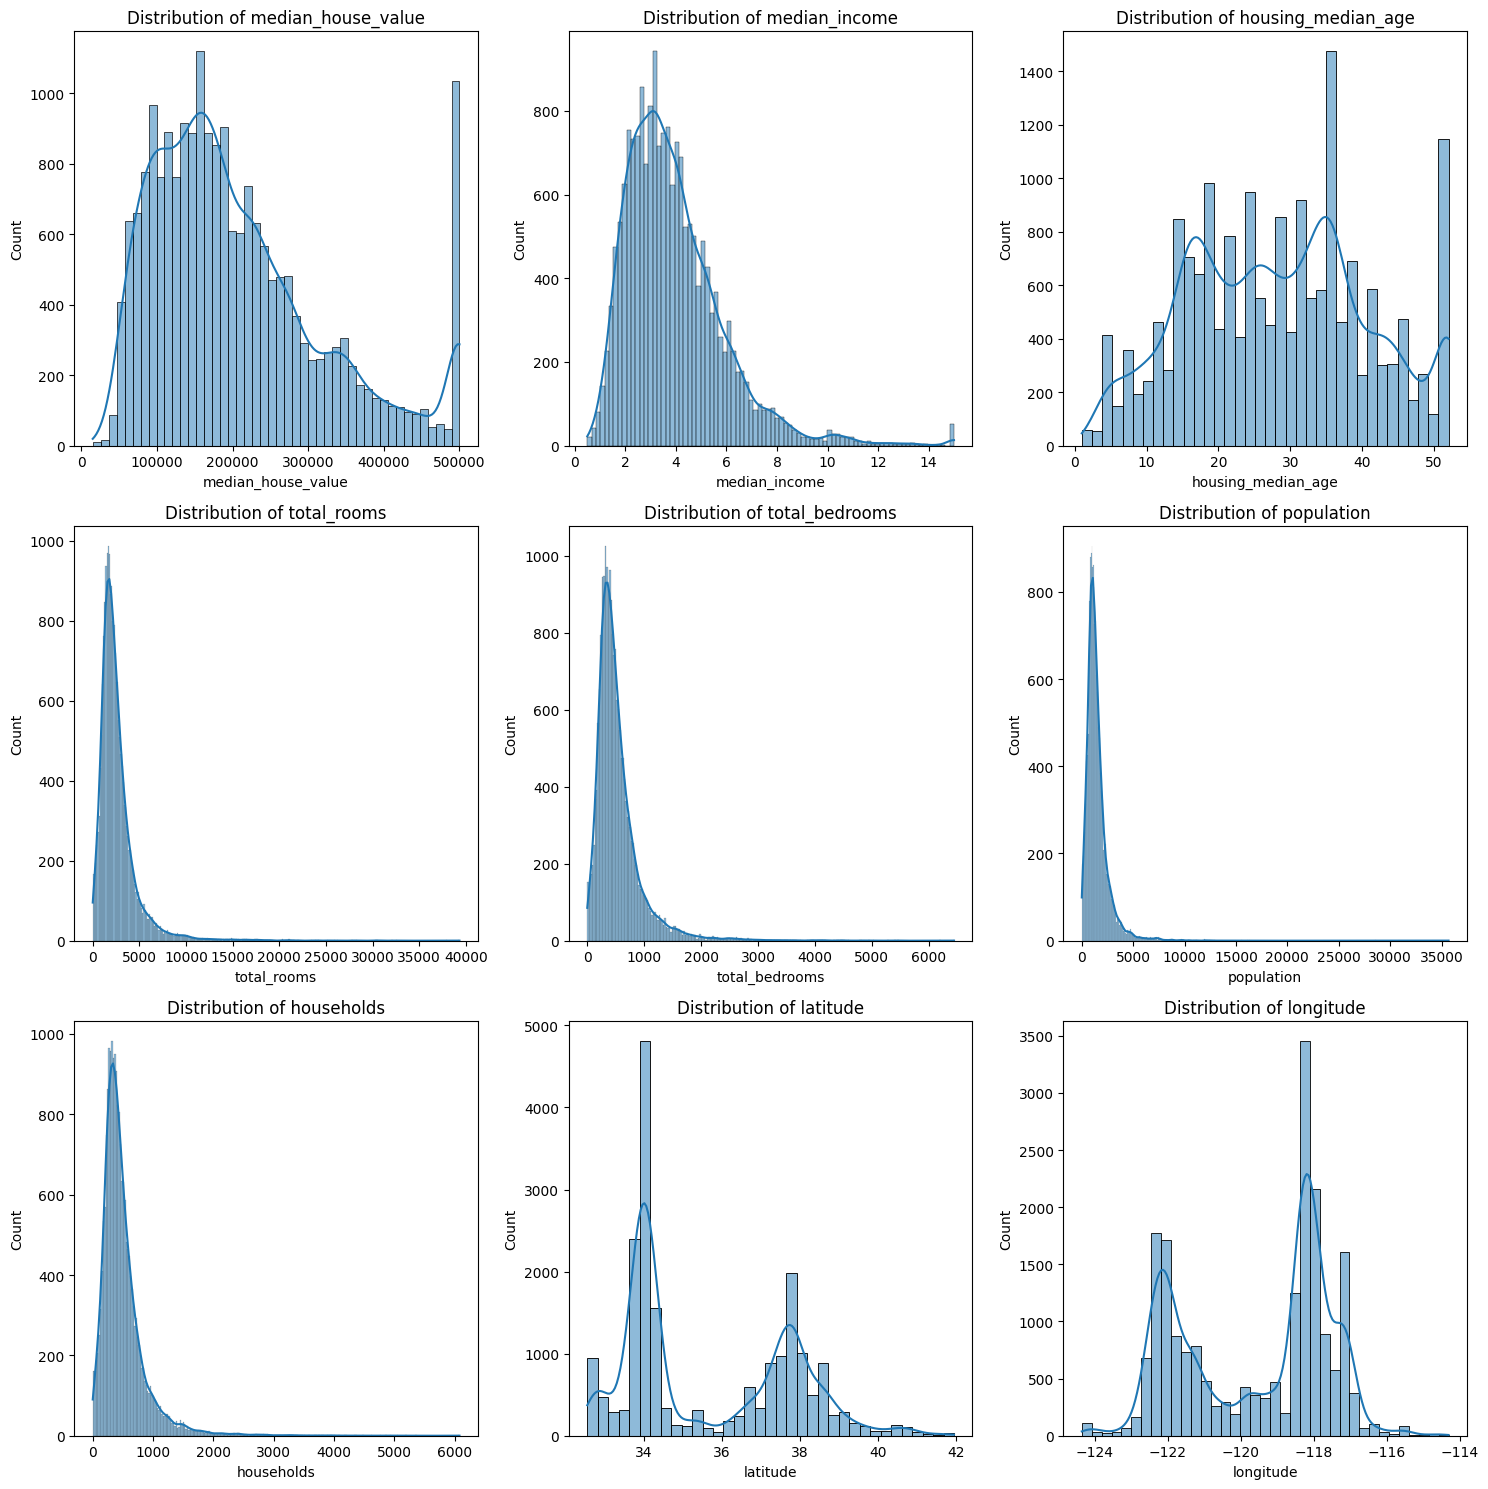

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numeric_cols = houses_corrupted.select_dtypes(include=[np.number]).columns.tolist()

n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols


fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(houses_corrupted[col], kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


From the above histograms, I was able to make the following observations:

* There is heavy skewness in features such as total_rooms, total_bedrooms, population, and households, indicating the presence of potential outliers.
* As noted earlier from the descriptive statistics analysis, the histograms further show  evidence of apparent capping for median_house_value and housing_median_age. The disproportionately high frequencies observed in the bars at the upper limits of these distributions suggest values are being truncated here.
* The way the data is grouped in latitude and longitude shows that houses are concentrated in certain areas. These locations could possibly affect other features, like house prices.


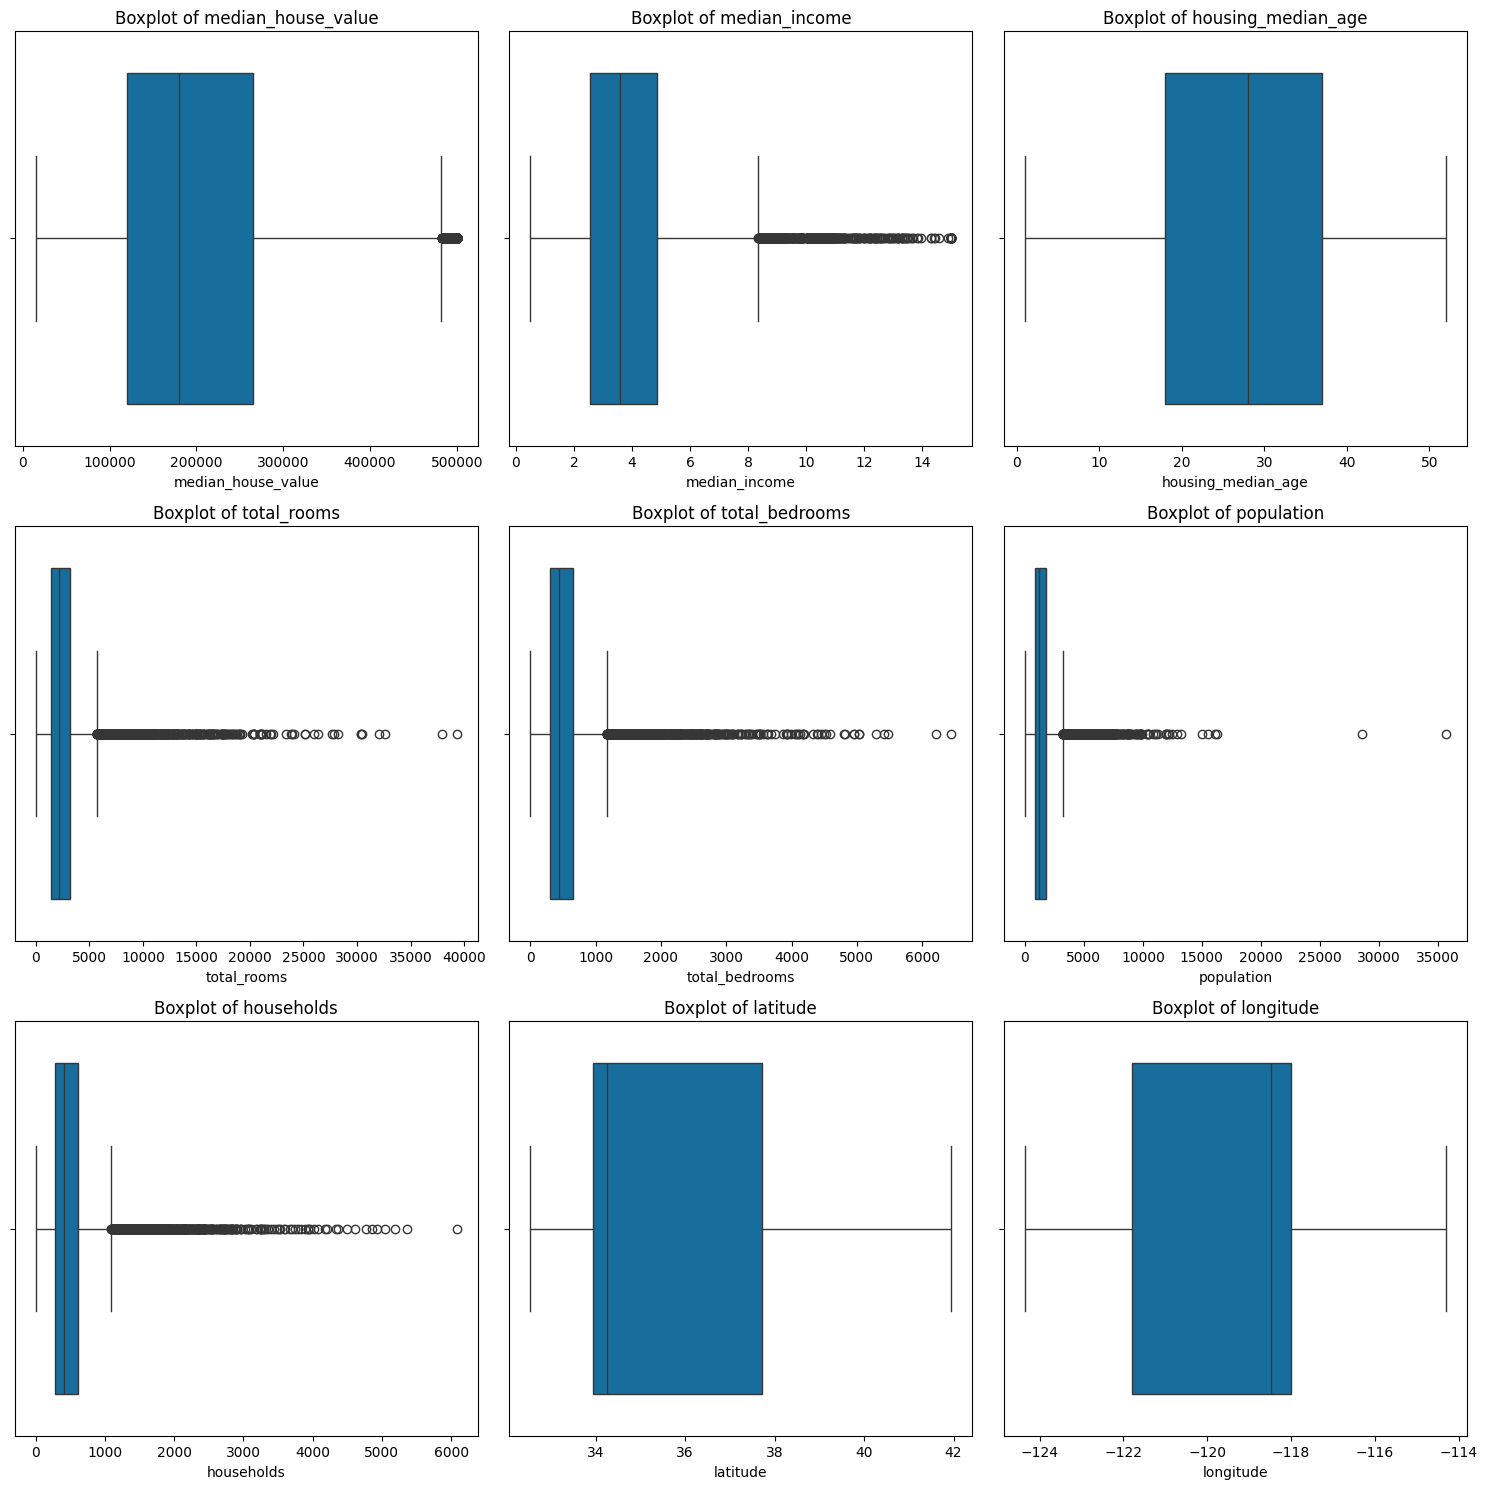

In [22]:
numeric_cols = houses_corrupted.select_dtypes(include=[np.number]).columns.tolist()

n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols


fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=houses_corrupted[col], ax=axs[i])
    axs[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


From the above boxplots:

* I can once again confirm the existence of numerous outliers in total_rooms, total_bedrooms, population, households, and median_income.
* median_house_value also shows points beyond the boxplot whiskers, but it is not as dramatic.
* housing_median_age, latitude, and longitude appear relatively more constrained, and fewer identified outliers can be noticed from a simple visual inspection.


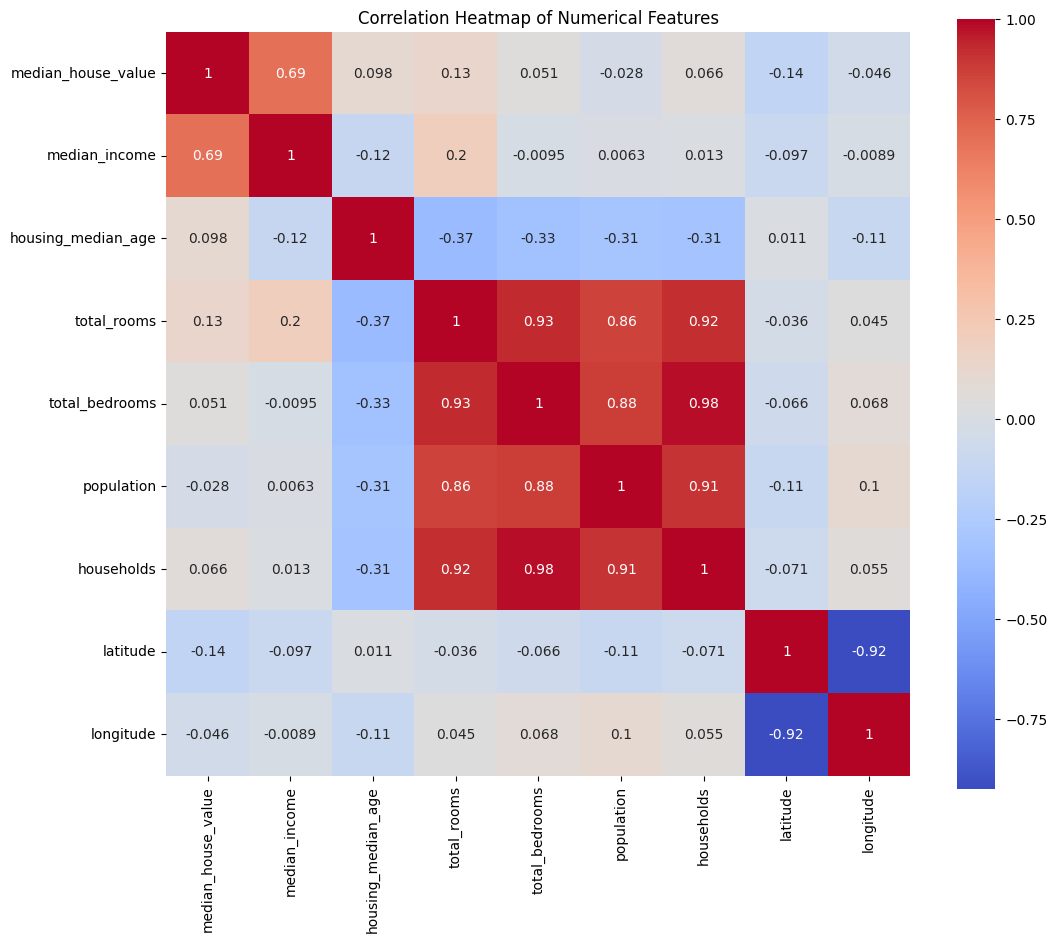

In [9]:
plt.figure(figsize=(12, 10))
corr_matrix = houses_corrupted[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

From the above correlation matrix, I made the following observations:

* There is a strong positive correlation among features related to housing density (total_rooms, total_bedrooms, population, and households). These variables may be somewhat redundany as they measure similar aspects of a neighbourhood’s scale.
* median_income and median_house_value have a moderately strong positive correlation of 0.69. This suggests that income is a key factor that influencproperty values.
* Geographic features such as latitude and longitude have a strong negative correlation of -0.91.

These insights can help me during feature selection, and further provide context for modelling decisions as I might not need all density-related features.


In [10]:
outlier_info = {}
for col in numeric_cols:
    if houses_corrupted[col].isnull().all():
        continue

    Q1 = houses_corrupted[col].quantile(0.25)
    Q3 = houses_corrupted[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = houses_corrupted[(houses_corrupted[col] < lower_bound) | (houses_corrupted[col] > upper_bound)][col]
    outlier_info[col] = len(outliers)

print("\nNumber of outliers identified by IQR rule for each numerical feature:")
for k, v in outlier_info.items():
    print(f"{k}: {v}")


Number of outliers identified by IQR rule for each numerical feature:
median_house_value: 1071
median_income: 562
housing_median_age: 0
total_rooms: 1287
total_bedrooms: 1282
population: 1077
households: 1220
latitude: 0
longitude: 0


Using an IQR-based method, I was able to identify outliers in all features (as they are all numeric). Many variables, especially those relating to size (such as  rooms, bedrooms, population, households) and median_house_value, have over a thousand points outside the IQR bounds.

On the other hand, features such as housing_median_age, latitude, and longitude have zero outliers by this definition.

This confirms my previous observations from the histograms and boxplots that the outliers are widespread. These outliers, however, may not all necessarily be errors, as some neighbourhoods could genuinely be larger or denser. This once again means I will have to be careful in handling these extreme values and use stronger outlier detection methods compared to the simple IQR-based method I used here.


#### EDA Summary

Summary
From my exploratory data analysis of the corrupted housing dataset, I was able to observe the key points:
Missing Data: Three features (median_income, housing_median_age, and population) each have about 10% missing values. While these are not excessively high, I will have to be careful in handling them. Imputation will be necessary, or I will otherwise lose a significant portion of the dataset if I drop these values.
Data Distributions and Outliers: The dataset is highly skewed for most features, with many extreme values that qualify as outliers. The outliers can affect any models I may use in the future, so I will have to address them.
Correlations: There are strong correlations among certain groups of features (room counts and population metrics), which could suggest redundancy as detailed in the correlation analysis section above.
From this EDA phase, I was able to determine which features have missing data that I need to impute, which features have extensive outliers and which variables are likely to be most informative for predicting median_house_value.


### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


In [11]:
import scipy.stats as stats

for col in numeric_cols:
    data = houses_corrupted[col].dropna()
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    print(f"{col}: skew={skewness:.2f}, kurt={kurtosis:.2f}")


median_house_value: skew=0.98, kurt=0.33
median_income: skew=1.59, kurt=4.50
housing_median_age: skew=0.09, kurt=-0.79
total_rooms: skew=4.15, kurt=32.62
total_bedrooms: skew=3.45, kurt=21.92
population: skew=4.83, kurt=70.42
households: skew=3.41, kurt=22.05
latitude: skew=0.47, kurt=-1.12
longitude: skew=-0.30, kurt=-1.33


In order to identify the most suitable outlier detection methods for this dataset, I analyzed the skewness and kurtosis of the data. Based on the above output:

* Z-score and IQR methods are suitable for median_house_value, median_income, housing_median_age, latitude, and longitude because these variables have low to moderate skewness and kurtosis, showing near-normal distributions. Overall, IQR is the best option because it handles small deviations from normality better, especially for moderately skewed features like median_income.
* Methods like Z-score and IQR may not work well for total_rooms, total_bedrooms, population, and households because these variables are highly skewed and asymmetric, making traditional methods less effective at identifying outliers. Instead, Isolation Forest is a better choice because it handles skewed and heavy-tailed data without needing any distributional assumptions.

Based on this analysis, I shall use IQR and Isolation Forest (IF). IQR would be best suited for variables with near-normal distributions and IF for highly skewed variables.



In [23]:
from sklearn.ensemble import IsolationForest


numeric_cols = houses_corrupted.select_dtypes(include=[np.number]).columns.tolist()


outliers_iqr = pd.Series(False, index=houses_corrupted.index)

for col in numeric_cols:
    col_data = houses_corrupted[col].dropna() # In order to perform IQR, I had to drop all NA values.
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_iqr = outliers_iqr | ((houses_corrupted[col] < lower_bound) | (houses_corrupted[col] > upper_bound))

num_outliers_iqr = outliers_iqr.sum()
print(f"Number of outliers detected by IQR method: {num_outliers_iqr}")

Number of outliers detected by IQR method: 2911


Using the IQR-based approach, I identified 2,911 outliers, which is quite a large fraction of the data. Since many features are heavily skewed, IQR will flag extreme values as outliers due to its univariate approach. While IQR handles mild deviations from normality well, very skewed distributions can produce many outliers. This means that IQR may over-identify outliers in highly skewed features.

In [13]:

X = houses_corrupted[numeric_cols].dropna()  # To perform IF, I had to once again drop all NA values.
if X.isnull().sum().sum() > 0:
    X = X.dropna()

iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_preds = iso_forest.fit_predict(X)

outliers_iso = (iso_preds == -1)
num_outliers_iso = outliers_iso.sum()
print(f"Number of outliers detected by Isolation Forest: {num_outliers_iso}")

Number of outliers detected by Isolation Forest: 753


Using Isolation Forest, set with a 5% contamination rate, I identified 753 outliers. This is significantly fewer than what the IQR approach produced. Given that Isolation Forest is multivariate and does not rely on distributional assumptions, it focuses on points that are truly hard to fit within the overall pattern of the data and not just extreme values in one feature.

This suggests that Isolation Forest may provide a more refined set of outliers, possibly highlighting anomalies that stand out in the multidimensional space rather than simply marking all large values as outliers.


In [14]:
iqr_filtered = outliers_iqr.loc[X.index]

overlap = (iqr_filtered & outliers_iso).sum()
print(f"Overlap in outliers detected by both methods: {overlap}")

Overlap in outliers detected by both methods: 701


Out of the outliers that were identified by both methods, 701 were flagged as outliers by the IQR and Isolation Forest methods. The fact that most of the Isolation Forest outliers overlap with IQR outliers despite IQR finding more outliers is quite informative.

 These 701 cases are likely the most certain outliers, as they are unusual in both univariate (IQR) and multivariate (IF) analyses. I will have to carefully review these, as they could be rare cases or data errors. Having identified these, I can now better prioritize which anomalies to address.


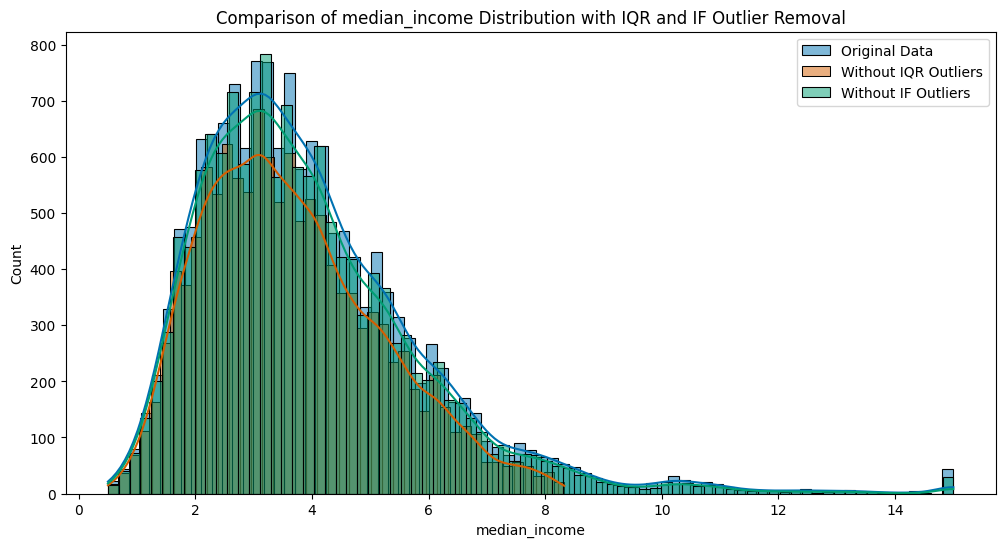

In [24]:
X_index = X.index

non_outliers_iqr_in_X = X_index[~outliers_iqr.loc[X_index]]
non_outliers_if_in_X = X_index[~outliers_iso]

feature = 'median_income'  # From my previous analysis and how often median income is a predictor for mean house value, I determined it to be the best choice to visualize.

plt.figure(figsize=(12,6))
sns.set_palette("colorblind")

sns.histplot(X[feature].dropna(), kde=True, color='#0072B2', label='Original Data', alpha=0.5)  # Blue

sns.histplot(X.loc[non_outliers_iqr_in_X, feature].dropna(), kde=True, color='#D55E00', label='Without IQR Outliers', alpha=0.5)  # Orange

sns.histplot(X.loc[non_outliers_if_in_X, feature].dropna(), kde=True, color='#009E73', label='Without IF Outliers', alpha=0.5)  # Green

plt.title("Comparison of median_income Distribution with IQR and IF Outlier Removal")
plt.legend()
plt.show()


Based on the above histogram, I was able to make the following observations:

* Original vs. Without IQR Outliers: The IQR method removes many high-income points, making the distribution look cleaner and less skewed. However, it may also exclude points that represent wealthy neighbourhoods and not true anomalies.
* Original vs. Without IF Outliers: IF is more selective, considering all features together to find truly anomalous points. After using IF, the distribution remained closer to the original, with less drastic removal of high values compared to IQR. This suggests that IF captures fewer but more meaningful anomalies, while preserving the overall distribution shape.
* Comparing IQR and IF Outlier Removal: The IQR removal sharply cuts the tail, while IF makes more subtle changes. This shows that IF better distinguishes rare, but valid points, from true anomalies. The difference between the 'Without IQR Outliers' and 'Without IF Outliers' lines shows how IQR can be overly strict compared to IF's nuanced, multivariate approach.


#### Final Summary/Analysis


Using a skewness and kurtosis analysis of the data, I was able to assess the dataset's distribution and applied two outlier detection methods: the univariate IQR and the multivariate Isolation Forest. These are my summarized observations:

* IQR Results: The IQR method flagged 2,911 outliers. While IQR handles mild non-normality well, it still flags univariate extremes as outliers. This led to many outliers being identified in highly skewed features.
* Isolation Forest Results: Isolation Forest, using a multivariate approach, identified fewer outliers (753), showing it is more selective by detecting points that are anomalous across all features.
* Overlap: The 701 overlapping outliers represent a core set of anomalies agreed upon by both methods, likely marking the most unusual records in the dataset.
* Visual Impact: My plotted histogram compared median_income distributions before and after IQR and IF outlier removal, and showed how each method impacted the distribution. Both reduced extreme values, but IQR removed more points, potentially excluding legitimate high-income regions. Isolation Forest removed fewer outliers, preserving the natural shape of the distribution and focusing on truly anomalous points.


### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [17]:
# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

In [18]:
import pandas as pd
from sklearn.impute import KNNImputer

houses_corrupted_knn = houses_corrupted.copy()

numeric_cols = houses_corrupted_knn.select_dtypes(include=[float, int]).columns
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform')
houses_corrupted_knn[numeric_cols] = imputer_knn.fit_transform(houses_corrupted_knn[numeric_cols])


I have now applied KNN imputation to the numeric features of the corrupted dataset. The missing values are filled based on the nearest neighbors, producing a complete dataset (houses_corrupted_knn) without missing entries.

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

houses_corrupted_mice = houses_corrupted.copy()

imputer_mice = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42),
                                max_iter=10, random_state=42)
houses_corrupted_mice[numeric_cols] = imputer_mice.fit_transform(houses_corrupted_mice[numeric_cols])


I have now applied MICE-like imputation using a Random Forest Regressor for iterative predictions. This should result in a  fully imputed dataset that can potentially capture more complex relationships than KNN did.

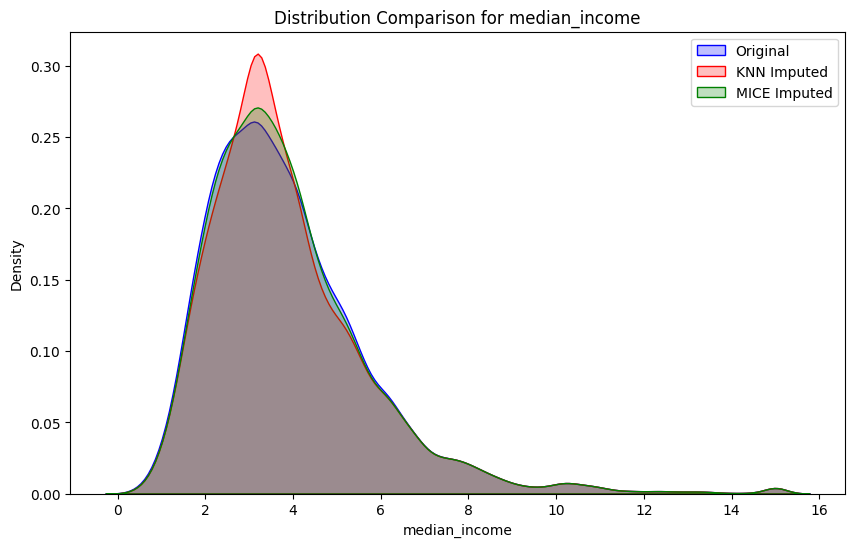

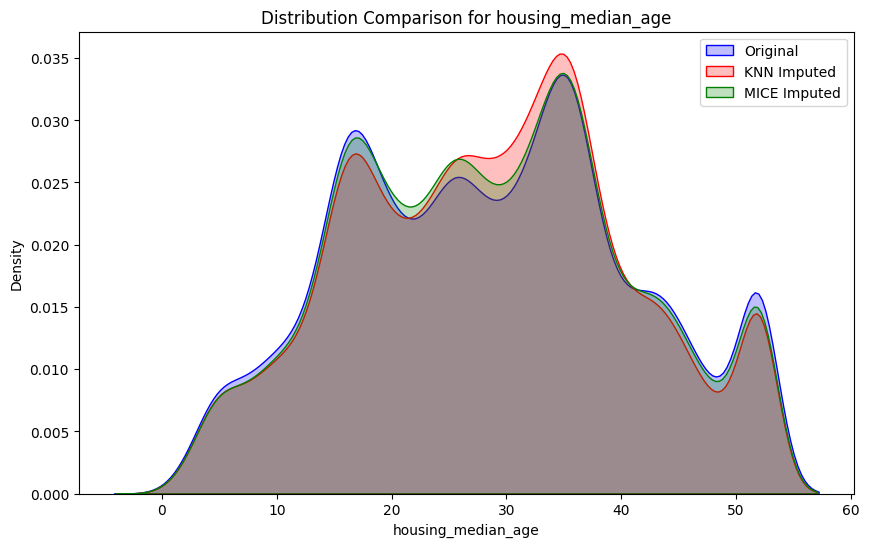

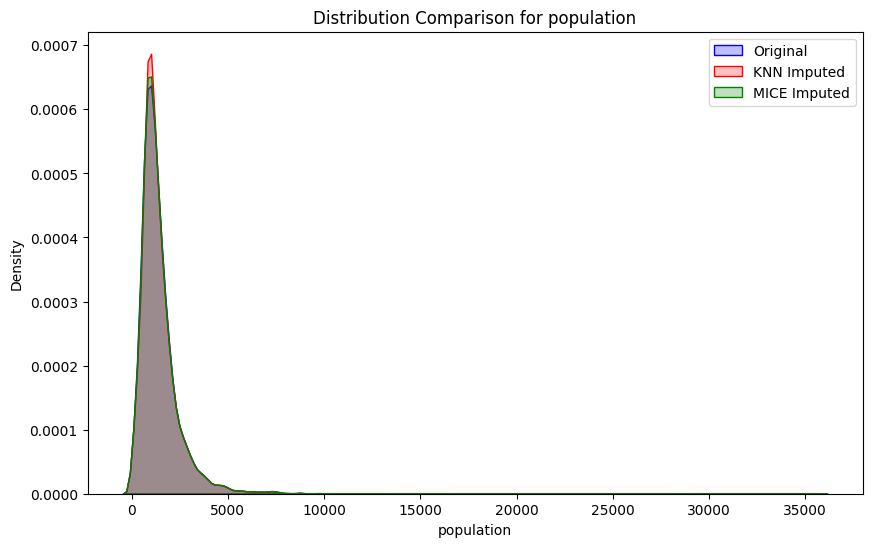

In [25]:
features_to_compare = ['median_income', 'housing_median_age', 'population']

for feat in features_to_compare:
    plt.figure(figsize=(10,6))
    sns.kdeplot(houses[feat], label='Original', fill=True, color='blue')
    sns.kdeplot(houses_corrupted_knn[feat], label='KNN Imputed', fill=True, color='red')
    sns.kdeplot(houses_corrupted_mice[feat], label='MICE Imputed', fill=True, color='green')
    plt.title(f"Distribution Comparison for {feat}")
    plt.legend()
    plt.show()


The above plots show how the distributions of median_income, housing_median_age, and population vary across the original, KNN-imputed, and MICE-imputed datasets. By examining the curves, I was able to make the following observations:

* median_income: KNN imputation shifts the distribution slightly, creating a sharper peak (red). MICE (green) stays closer to the original (blue), keeping the distribution's shape more intact.

* housing_median_age: KNN changes the shape slightly, making some peaks more noticeable, while MICE remains closer to the original distribution.

* population: Both methods are similar to the original distribution, though KNN slightly shortens the tail. MICE is almost identical to the original.


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return r2, rmse

target = 'median_house_value'
features = [col for col in numeric_cols if col != target]

X_original = houses[features]
y_original = houses[target]
r2_orig, rmse_orig = evaluate_model(X_original, y_original)

X_knn = houses_corrupted_knn[features]
y_knn = houses_corrupted_knn[target]
r2_knn, rmse_knn = evaluate_model(X_knn, y_knn)

X_mice = houses_corrupted_mice[features]
y_mice = houses_corrupted_mice[target]
r2_mice, rmse_mice = evaluate_model(X_mice, y_mice)

print("Original Data: R² =", r2_orig, "RMSE =", rmse_orig)
print("KNN Imputed Data: R² =", r2_knn, "RMSE =", rmse_knn)
print("MICE Imputed Data: R² =", r2_mice, "RMSE =", rmse_mice)


Original Data: R² = 0.8087856630254366 RMSE = 50056.86605650104
KNN Imputed Data: R² = 0.8075809632978681 RMSE = 50214.30406556869
MICE Imputed Data: R² = 0.8025588768518187 RMSE = 50865.373334651136


I used the model's performance on the original dataset as a baseline. Based on this, the KNN-imputed dataset performed slightly worse but remained close to the original, showing that KNN imputation did not significantly affect predictive power. MICE imputation also performed well, though its R² was marginally lower and its RMSE slightly higher. While MICE closely preserved the distribution shapes, the small difference in performance may be due to factors such as the complexity of relationships, random fluctuations, or parameter settings in the imputation process.

#### Conclusion on Models:

Among the three datasets, the original dataset’s model performed the best, with the KNN-imputed model following closely and the MICE-imputed model slightly behind. The KNN-imputed model’s slightly better performance over MICE might be due to its simpler approach, which effectively captures local neighbourhood patterns.

On the other hand, MICE, while being better at preserving the data's statistical characteristics, may introduce a more complex approximation that marginally affects its predictive accuracy.

Overall, these performance differences are small, making both methods viable for me to use. KNN may be preferred for its simplicity and slightly better results, but MICE is still a strong option for me to use when maintaining the data's original distributions is the priority.


### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation

* Anomaly Detection Methods (IQR and Isolation Forest):

During this process, I used both IQR and Isolation Forest to identify outliers. From my experience, IQR is widely regarded as a straightforward method because it simply uses the spread of the central portion of the data. This made it easy for me to implement and interpret. However, I noticed that for heavily skewed features, IQR tended to flag many points as outliers, potentially removing data that might actually represent legitimate neighbourhoods with large values.

On the other hand, Isolation Forest considered all features together and was more selective. By focusing on points that are harder to fit into the overall pattern, it found fewer outliers. This made me feel more confident that the points identified by Isolation Forest were genuinely unusual. The trade-off is that Isolation Forest is more complex, and tuning it required more thought and parameter selection.

* Challenges in Anomaly Detection:

I found it challenging to decide which threshold or contamination level to use. The skewed distributions meant that simple methods could easily over-flag outliers, while more complex methods like Isolation Forest required careful tuning. Another difficulty was determining whether outliers were actual anomalies or just rare but valid data points. Without knowing enough about the topic, it was hard to figure out what to do with these unusual data points.

* Imputation Methods (KNN and MICE):

For handling missing values, I tried both KNN and MICE. KNN was simpler and ran quickly, and while it sometimes slightly changed the shape of certain feature distributions, it generally allowed my predictive model to perform nearly as well as the original data. MICE took a more iterative and comprehensive approach, which helped preserve the natural shape of the distributions better.

However, this complexity came at a cost, as the predictive performance on the MICE-imputed data was a bit lower than KNN’s. This runtime was negligible for this particular dataset, but given that I could notice a difference in runtime indicates how much more computationally expensive it is, and how long it could take for a much larger dataset.

* Challenges in Imputation:

Choosing the right imputation method depended on my priority: simplicity and speed, or keeping the data's details intact. KNN was quick to set up but made the data more uniform. MICE required more computations and parameter adjustments. While it did keep the data looking more realistic, it did not improve predictive results in my test. Balancing data quality and model performance isn’t always easy and might need more tuning or trying different settings in MICE.
